<font color='blue' size='7'>**Домашняя работа**</font>  
<font color='1A9BFF' size='6'>**Тема: Машинное обучение. Линейные алгоритмы**</font>  
<font size='5'>**Задание:**</font>  

1. Загрузите данные о пассажирах Титаника. Данные можно скачать с сайта Kaggle по ссылке https://www.kaggle.com/c/titanic/data?select=train.csv или загрузить из библиотеки Seaborn командой sns.load_dataset('titanic').
2. Проверьте данные на наличие пропусков и обработайте их.
3. Если в данных присутствуют категориальные переменные, проведите их обработку.
4. Постройте алгоритм K-ближайших соседей (KNN). Для выбора оптимальных гиперпараметров используйте метод gridsearch.
5. Проверьте, насколько модель переобучена, используя кросс-валидацию.
6. Рассчитайте метрики качества модели: матрицу ошибок, accuracy, precision, recall и AUC-ROC.
7. Построите модель логистическая регрессия с регуляризацией. Тип регуляризации и параметр регуляризации $\alpha$ подобрать с помощью gridsearch.




<font size='5'>**Решение:**</font>  

<font color='1A9BFF'>**Установка и импорт необходимых библиотек**</font>

In [1]:
# для обработки категориальных переменных
# !pip install category_encoders -q

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

<font color='1A9BFF'>**Загрузите набор данных титаник**</font>

In [3]:
df = pd.read_csv('/Users/dinara/Applications/Solving-problems-from-courses/Аналитика данных и машинное обучение/Регуляризация. Гребневая регрессия. Лассо/train.csv')

## EDA

<font color='1A9BFF'>**Посмотрите на первые 5 строк**</font>

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<font color='1A9BFF'>**Проверьте, все ли типы данных верные. Если где-то назанчен неверный тип данных, исправьте**</font>



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


><font color='green'>
Датасет Titanic с 12 столбцами выглядит корректно с точки зрения типов данных.

- PassengerId (int64): Идентификатор пассажира. Тип данных правильный, так как это уникальные числовые значения.
- Survived (int64): Индикатор выживания (0 = не выжил, 1 = выжил). Тип данных правильный, так как это бинарные значения, представленные целыми числами.
- Pclass (int64): Класс обслуживания (1 = 1-й, 2 = 2-й, 3 = 3-й). Тип данных правильный, так как это числовые категории.
- Name (object): Имя пассажира. Тип данных правильный, так как это строковые данные.
- Sex (object): Пол пассажира. Тип данных правильный, так как это строковые данные.
- Age (float64): Возраст пассажира. Тип данных правильный, так как возраст может быть дробным значением (например, 22.5 года).
- SibSp (int64): Количество братьев, сестер и супругов на борту. Тип данных правильный, так как это числовые значения.
- Parch (int64): Количество родителей и детей на борту. Тип данных правильный, так как это числовые значения.
- Ticket (object): Номер билета. Тип данных правильный, так как номера билетов могут содержать буквы и цифры.
- Fare (float64): Плата за проезд. Тип данных правильный, так как это дробные значения.
- Cabin (object): Номер каюты. Тип данных правильный, так как номера кают могут содержать буквы и цифры.
- Embarked (object): Порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton). Тип данных правильный, так как это строковые данные.
</font>

<font color='1A9BFF'>**Проверка на пропуски**</font>



In [6]:
# Проверка на пропуски
missing_values = df.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


><font color='green'>
Анализируя пропущенные значения в вашем датасете Titanic, можно сделать следующие выводы:

Age: 177 пропущенных значений. Возраст может быть важным признаком для анализа выживаемости. Пропущенные значения можно заполнить средним, медианой, или предсказанными значениями с использованием других признаков (например, с помощью модели регрессии).

Cabin: 687 пропущенных значений. Столбец Cabin содержит слишком много пропусков, что делает его менее полезным для анализа. В зависимости от целей анализа можно либо исключить этот столбец, либо попытаться заполнить пропуски, используя информацию из других столбцов, например, разделив номера кают на палубы и анализируя только палубы.

Embarked: 2 пропущенных значения (менее 1% данных отсутствуют). Порт посадки также может быть важным признаком для анализа. Пропущенные значения можно легко заполнить самым частым значением (модой) или анализируя другие признаки, такие как класс обслуживания или плата за проезд.
</font>



<font color='1A9BFF'>**анализ категориальных переменных**</font>



сколько категориальных признаков

In [7]:
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
num_categorical = len(categorical_columns)

print(f"Количество категориальных признаков: {num_categorical}")

Количество категориальных признаков: 5


Посмотрите на значения категориальных признаков

In [8]:
for col in categorical_columns:
    print(f"\nЗначения признака {col}:")
    print(df[col].value_counts())


Значения признака Name:
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

Значения признака Sex:
male      577
female    314
Name: Sex, dtype: int64

Значения признака Ticket:
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Значения признака Cabin:
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34   

В модели будем использовать следующие категориальные признаки после их преобразования в числовые (с помощью one-hot encoding): sex, embarked, class, who, deck,embark_town, alive, alone

Исключенные признаки:

- cabin (из-за большого количества пропусков)
- name и ticket (поскольку они не несут значимой информации для классификации в данном контексте)

><font color='green'>
Таким образом, после обработки и преобразования категориальных признаков, мы можем построить и оценить модели KNN, а затем выбрать наилучшую модель на основе метрик качества.
</font>



## Подготовка датасета к построению моделей

<font color='red'>**! Важно! Все трансформеры обучаем на тренировочной выборке, к тестовой только применяем!**</font>



<font color='1A9BFF'>**Обработка пропусков**</font>



- Заполнение пропусков в столбце Age: использование среднего или медианного значения возраста.
- Обработка столбца Cabin: исключение столбца Cabin из анализа, если он не критичен для вашей задачи, из-за большого количества пропусков.
- Заполнение пропусков в столбце Embarked: заполнение пропусков самым частым значением (модой), так как всего 2 пропущенных значения не сильно повлияют на анализ.

In [9]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df.drop(columns=['Cabin'], inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB
None


<font color='1A9BFF'>**Обработка категориальных признаков**</font>



In [10]:
# Преобразование категориальных переменных в числовые с помощью one-hot encoding
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Проверка результата
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare  Sex_male  Embarked_Q  Embarked_S  
0         A/5 21171   7.2500         1           0           1  
1          PC 17599  71.2833         0           0           0  
2  STON/O2. 3101282   7.9250         0           0           1  
3            113803  53.1000         0           0           1  
4

## Разделим выборку на тренировочную и тестовую

In [11]:
from sklearn.model_selection import train_test_split

# Определение признаков и целевой переменной
X = df.drop(columns=['Survived', 'Name', 'Ticket'])
y = df['Survived']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Построение модели knn

<font color='1A9BFF'>**1. Задайте сетку параметров для параметров: n_neighbors, p**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выберите наилучшие параметры n_neighbors, p**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации убедитесь, что модель с минимальным переобучением**</font>



In [12]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Определение модели и гиперпараметров для GridSearchCV
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21, 5), 'p': [1, 2]}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Оптимальные гиперпараметры
print(f"Best parameters: {grid_search.best_params_}")

# Оценка качества модели на тестовых данных
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)


Best parameters: {'n_neighbors': 6, 'p': 2}


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(f"Confusion Matrix:\n{conf_matrix}")

# Метрики качества
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
roc_auc = roc_auc_score(y_test, best_knn.predict_proba(X_test_scaled)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {roc_auc}")

Confusion Matrix:
[[92 13]
 [26 48]]
Accuracy: 0.7821229050279329
Precision: 0.7868852459016393
Recall: 0.6486486486486487
AUC-ROC: 0.8633204633204633


In [15]:

cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation scores: [0.81818182 0.81818182 0.82394366 0.79577465 0.82394366]
Mean CV accuracy: 0.8160051216389246


In [16]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(f"Confusion Matrix:\n{conf_matrix}")

# Метрики качества
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
roc_auc = roc_auc_score(y_test, best_knn.predict_proba(X_test_scaled)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {roc_auc}")

Confusion Matrix:
[[92 13]
 [26 48]]
Accuracy: 0.7821229050279329
Precision: 0.7868852459016393
Recall: 0.6486486486486487
AUC-ROC: 0.8633204633204633


## Построение модели логистическая регрессия

<font color='1A9BFF'>**1. Задайте сетку параметров для параметров: тип регуляризации, параметр регуляризации**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выберите наилучшие параметров**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации убедитесь, что модель с минимальным переобучением**</font>



In [17]:

# Определение модели и гиперпараметров для GridSearchCV
logreg = LogisticRegression(solver='liblinear')
param_grid = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logreg__penalty': ['l1', 'l2']}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', logreg)
])

grid_search_logreg = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train, y_train)

# Оптимальные гиперпараметры
print(f"Best parameters for Logistic Regression: {grid_search_logreg.best_params_}")

Best parameters for Logistic Regression: {'logreg__C': 0.1, 'logreg__penalty': 'l2'}


## Оценка качества  моделей и выбор наилучшей



<font color='1A9BFF'>**Посчитайте метрики качества: матрицу ошибок, accuracy, precision, recall, AUC ROC**</font>   

In [18]:
# Оценка качества модели на тестовых данных
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)

# Метрики качества
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])

print(f"Logistic Regression - Confusion Matrix:\n{conf_matrix_logreg}")
print(f"Logistic Regression - Accuracy: {accuracy_logreg}")
print(f"Logistic Regression - Precision: {precision_logreg}")
print(f"Logistic Regression - Recall: {recall_logreg}")
print(f"Logistic Regression - AUC-ROC: {roc_auc_logreg}")

Logistic Regression - Confusion Matrix:
[[89 16]
 [19 55]]
Logistic Regression - Accuracy: 0.8044692737430168
Logistic Regression - Precision: 0.7746478873239436
Logistic Regression - Recall: 0.7432432432432432
Logistic Regression - AUC-ROC: 0.8752895752895752



<font color='1A9BFF'>**постройте график ROC кривой**</font>   

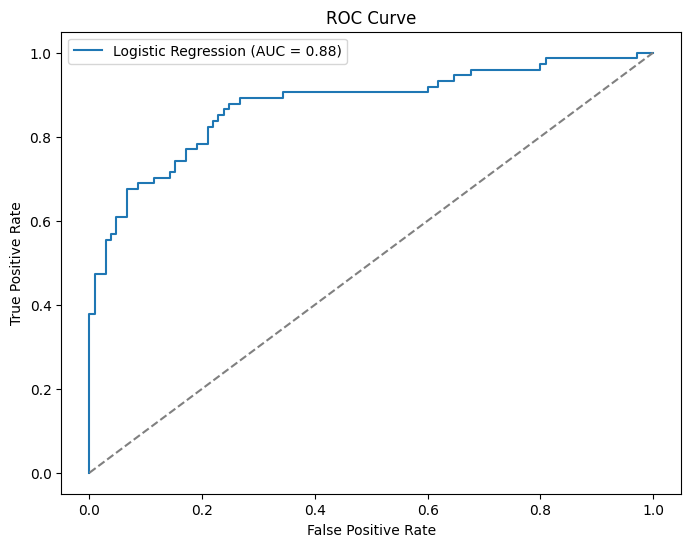

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Получение предсказанных вероятностей для логистической регрессии
y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_logreg)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_logreg))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


<font color='1A9BFF'>**Сравните модель knn и модель логистическая регрессия, выберите наилучшую и сделайте выводы**</font>   



><font color='green'>

Выводы
- Accuracy: Логистическая регрессия имеет более высокое значение accuracy (0.804) по сравнению с KNN (0.782).
- Precision: KNN немного превосходит логистическую регрессию по precision (0.787 против 0.775), что означает, что KNN лучше распознает положительные классы среди всех предсказанных положительных классов.
- Recall: Логистическая регрессия имеет более высокое значение recall (0.743), что означает, что она лучше захватывает все истинные положительные классы по сравнению с KNN (0.649).
- AUC-ROC: Логистическая регрессия имеет более высокое значение AUC-ROC (0.875), что указывает на лучшую общую производительность модели по сравнению с KNN (0.863).

Итог: исходя из предоставленных метрик, логистическая регрессия показывает лучшую общую производительность по сравнению с моделью KNN. Она демонстрирует более высокие значения accuracy, recall и AUC-ROC, что делает ее предпочтительной моделью для данной задачи.
</font>

